In [4]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

cudnn.benchmark = True

#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

#loading the dataset
dataset = dset.CIFAR10(root="./data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
nc=3

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True, num_workers=2)

#checking the availability of cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# number of gpu's available
ngpu = 1
# input noise dimension
nz = 100
# number of generator filters
ngf = 64
#number of discriminator filters
ndf = 64

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
            return output

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
#load weights to test the model
#netG.load_state_dict(torch.load('weights/netG_epoch_24.pth'))
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#load weights to test the model 
#netD.load_state_dict(torch.load('weights/netD_epoch_24.pth'))
print(netD)

criterion = nn.BCELoss()

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(128, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

niter = 25
g_loss = []
d_loss = []

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float32, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, niter, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        #save the output
        if i % 100 == 0:
            print('saving the output')
            vutils.save_image(real_cpu,'output/real_samples.png',normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),'output/fake_samples_epoch_%03d.png' % (epoch),normalize=True)
            torch.save(netG.state_dict(), 'weights/netG_epoch_%d.pth' % (epoch))
            torch.save(netD.state_dict(), 'weights/netD_epoch_%d.pth' % (epoch))
    # Check pointing for every epoch


Random Seed:  9402
Files already downloaded and verified
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2

RuntimeError: Parent directory weights does not exist.

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)
# Create Discriminator and Generator instances on CUDA device
D = Discriminator().to(device)
G = Generator().to(device)
# Initialize optimizer for Discriminator and Generator
optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()
# Print info about the models
print(D)
print(G)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(256, 12

Starting Training Loop...
[0/200][0/196]	Loss_D: 1.5066	Loss_G: 1.4065	D(x): 0.5746	D(G(z)): 0.6011 / 0.2544
[0/200][50/196]	Loss_D: 0.2475	Loss_G: 4.5700	D(x): 0.8734	D(G(z)): 0.0978 / 0.0131
[0/200][100/196]	Loss_D: 0.4463	Loss_G: 3.6948	D(x): 0.7399	D(G(z)): 0.0968 / 0.0277
[0/200][150/196]	Loss_D: 0.5618	Loss_G: 3.1401	D(x): 0.7082	D(G(z)): 0.1407 / 0.0526
[1/200][0/196]	Loss_D: 0.4619	Loss_G: 2.6415	D(x): 0.7497	D(G(z)): 0.1214 / 0.0857
[1/200][50/196]	Loss_D: 0.6598	Loss_G: 2.4679	D(x): 0.6988	D(G(z)): 0.1954 / 0.1027
[1/200][100/196]	Loss_D: 0.4327	Loss_G: 3.3918	D(x): 0.7914	D(G(z)): 0.1472 / 0.0456
[1/200][150/196]	Loss_D: 0.3653	Loss_G: 4.9978	D(x): 0.9019	D(G(z)): 0.2054 / 0.0124
[2/200][0/196]	Loss_D: 0.3547	Loss_G: 3.8869	D(x): 0.7808	D(G(z)): 0.0439 / 0.0312
[2/200][50/196]	Loss_D: 0.4803	Loss_G: 3.0844	D(x): 0.7310	D(G(z)): 0.1103 / 0.0649
[2/200][100/196]	Loss_D: 0.5327	Loss_G: 4.1952	D(x): 0.8997	D(G(z)): 0.3281 / 0.0203
[2/200][150/196]	Loss_D: 2.1350	Loss_G: 0.7438	D

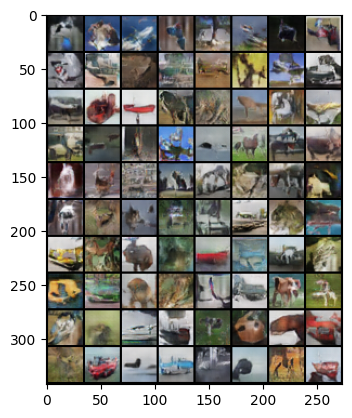

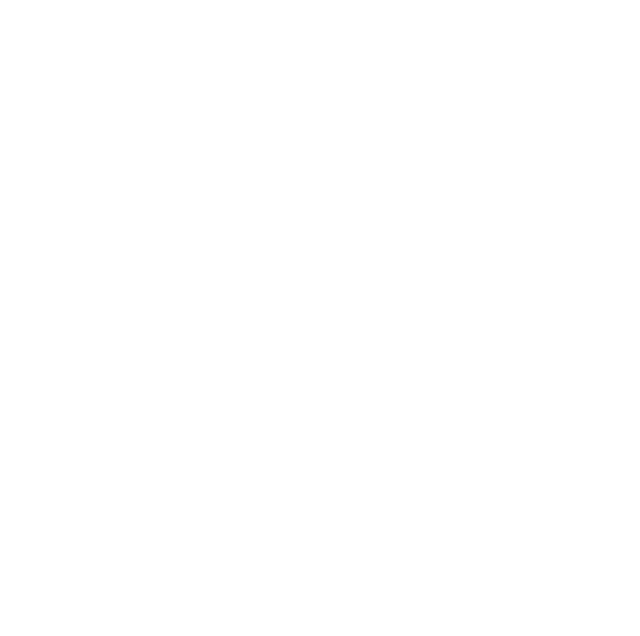

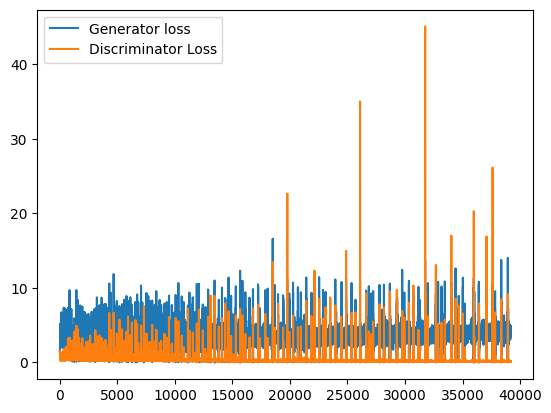

In [3]:
# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 200
# Training Loop
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):
        # Train with all-real batch
        D.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float32,device=device)
        output = D(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        # Train with all-fake batch
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = G(noise)
        label.fill_(0)
        output = D(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        # Update G network
        G.zero_grad()
        label.fill_(1)  # fake labels are real for generator cost
        output = D(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        # Output training stats
        if i % 50 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(train_dataloader)}]\t"
                  f"Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\t"
                  f"D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(train_dataloader) - 1)):
            with torch.no_grad():
                fake = G(noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            # Save the images to images folder

            vutils.save_image(fake, f"images/fake_images_{iters}.png")
            # Save animation

        iters += 1
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
fig = plt.figure(figsize=(8,8))
plt.axis("off")


# Save the model
torch.save(G.state_dict(), "saved_model/generator.pth")
plt.figure()
# Plot the training losses
plt.plot(G_losses, label='Generator loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

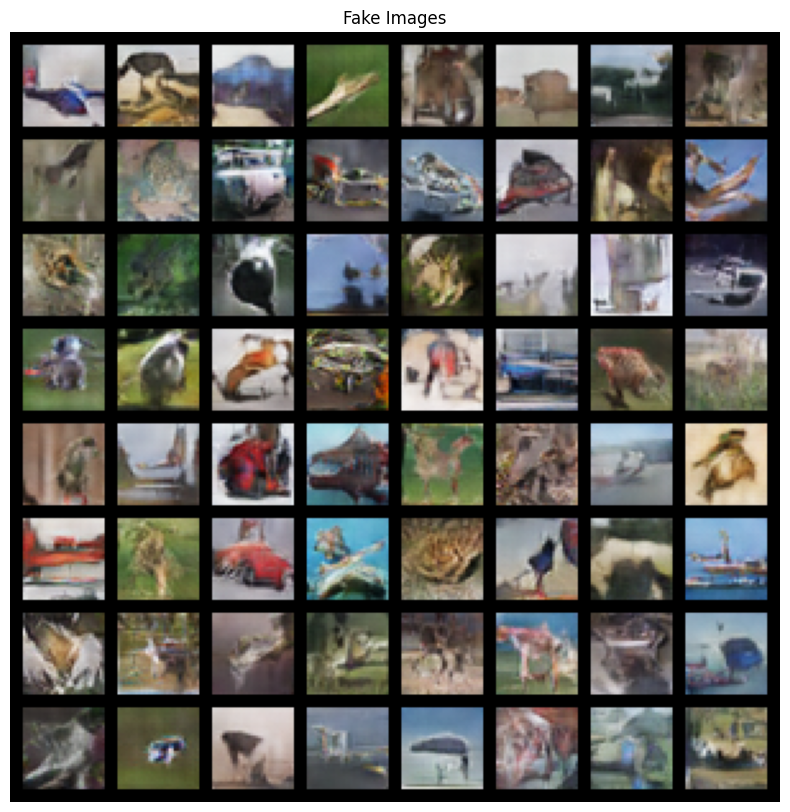

In [4]:
# Load the model
G = Generator().to(device)
G.load_state_dict(torch.load("saved_model/generator.pth"))
# Get random seed
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
# Generate fake images
fake = G(fixed_noise)
# Plot the fake images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
